In [1]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import MaxAbsScaler
from VotingClassifier import VotingClassifier
import pandas as pd
from pathlib import Path
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.svm import LinearSVC
from tabulate import tabulate

In [2]:
gbc_params = {
    "learning_rate": 0.85,
    "max_features": 0.05,
    "max_depth": 10,
    "min_samples_split": 520,
    "min_samples_leaf": 15,
    "n_estimators": 400
}

abc_params = {
    "algorithm": "SAMME.R",
    "learning_rate": 0.90,
    "n_estimators": 500
}

lsvc_params = {"C": 0.1}

In [3]:
# train data
base = Path().resolve().parents[1] / r'data/subsets/gender_final_small'
locations = [str(base) + str(i) + '.csv' for i in range(1, 10)]

# Have 9000 names sampled at random.
X = pd.concat([pd.read_csv(location) for location in locations], axis=0)
y = X["Gender"]
X.drop(labels="Gender", inplace=True, axis=1)

# validation data
validation_data = Path().resolve().parents[1] / 'data/gender_final_small.csv'
X_val = pd.read_csv(validation_data)
y_val = X_val["Gender"]
X_val.drop(labels="Gender", inplace=True, axis=1)

In [4]:
# vectorize and convert to floats
vectorizer = CountVectorizer(analyzer='char', ngram_range=(2,10), decode_error='replace', binary=True)
scaler = MaxAbsScaler()

X = vectorizer.fit_transform(X['Name'])
X = scaler.fit_transform(X)

X_val = vectorizer.transform(X_val['Name'])
X_val = scaler.transform(X_val)

In [5]:
abc_clf = AdaBoostClassifier(algorithm=abc_params["algorithm"],
                             n_estimators=abc_params["n_estimators"],
                             learning_rate=abc_params["learning_rate"],
                             random_state=0)

gbc_clf = GradientBoostingClassifier(learning_rate=gbc_params["learning_rate"],
                                     max_features=gbc_params["max_features"],
                                     min_samples_split=gbc_params["min_samples_split"],
                                     n_estimators=gbc_params["n_estimators"],
                                     max_depth=gbc_params["max_depth"],
                                     min_samples_leaf=gbc_params["min_samples_leaf"],
                                     random_state=0)

lsvc_clf = LinearSVC(C=lsvc_params['C'])
X_selected_main = []
X_val_selected_main = []

In [6]:
lsvc_clf.fit(X, y)
print("Using all features:Training ", lsvc_clf.score(X, y))
print("Using all features:Validation ", lsvc_clf.score(X_val, y_val))

selector = SelectFromModel(lsvc_clf, prefit=True)
X_selected = selector.transform(X)
X_selected_main.append(X_selected)
X_val_selected = selector.transform(X_val)
X_val_selected_main.append(X_val_selected)
print("Shaped reduced from {} to {}, difference is {}".format(X.shape[1],
                                                              X_selected.shape[1],
                                                              X.shape[1] - X_selected.shape[1]))

lsvc_clf.fit(X_selected, y)
print("Using selected features:Training ", lsvc_clf.score(X_selected, y))
print("Using selected features:Validation ", lsvc_clf.score(X_val_selected, y_val))

Using all features:Training  0.9934444444444445
Using all features:Validation  0.838
Shaped reduced from 63889 to 23805, difference is 40084
Using selected features:Training  0.9921111111111112
Using selected features:Validation  0.841


In [7]:
abc_clf.fit(X, y)
print("Using all features:Training ", abc_clf.score(X, y))
print("Using all features:Validation ", abc_clf.score(X_val, y_val))

selector = SelectFromModel(abc_clf, prefit=True)
X_selected = selector.transform(X)
X_selected_main.append(X_selected)
X_val_selected = selector.transform(X_val)
X_val_selected_main.append(X_val_selected)
print("Shaped reduced from {} to {}, difference is {}".format(X.shape[1],
                                                              X_selected.shape[1],
                                                              X.shape[1] - X_selected.shape[1]))

abc_clf.fit(X_selected, y)
print("Using selected features:Training ", abc_clf.score(X_selected, y))
print("Using selected features:Validation ", abc_clf.score(X_val_selected, y_val))

Using all features:Training  0.8517777777777777
Using all features:Validation  0.786
Shaped reduced from 63889 to 434, difference is 63455
Using selected features:Training  0.8517777777777777
Using selected features:Validation  0.786


In [8]:
gbc_clf.fit(X, y)
print("Using all features:Training ", gbc_clf.score(X, y))
print("Using all features:Validation ", gbc_clf.score(X_val, y_val))

selector = SelectFromModel(gbc_clf, prefit=True)
X_selected = selector.transform(X)
X_selected_main.append(X_selected)
X_val_selected = selector.transform(X_val)
X_val_selected_main.append(X_val_selected)
print("Shaped reduced from {} to {}, difference is {}".format(X.shape[1],
                                                              X_selected.shape[1],
                                                              X.shape[1] - X_selected.shape[1]))

gbc_clf.fit(X_selected, y)
print("Using selected features:Training ", gbc_clf.score(X_selected, y))
print("Using selected features:Validation ", gbc_clf.score(X_val_selected, y_val))

Using all features:Training  0.9297777777777778
Using all features:Validation  0.8
Shaped reduced from 63889 to 1088, difference is 62801
Using selected features:Training  0.9295555555555556
Using selected features:Validation  0.816


In [9]:
for i, _ in enumerate(X_selected_main):
    print(i, _.shape)

0 (9000, 23805)
1 (9000, 434)
2 (9000, 1088)


In [9]:
main_clf_hard = VotingClassifier(clfs=[lsvc_clf, abc_clf, gbc_clf], voting='hard')
main_clf_soft = VotingClassifier(clfs=[lsvc_clf, abc_clf, gbc_clf])
main_clf_hard.fit(X_selected_main, y)

`refit` set to False, not refitting the base estimators


In [10]:
print(len(X_selected_main), len(y))
print(len(X_val_selected_main), len(y_val))

3 9000
3 1000


In [11]:
# Will be same because there is no role of voting in score method.
print("Hard Combined training score is ", main_clf_hard.score(X_selected_main, y))
print("Hard Combined Validation score is ", main_clf_hard.score(X_val_selected_main, y_val))

print("Soft Combined training score is ", main_clf_soft.score(X_selected_main, y))
print("Soft Combined Validation score is ", main_clf_soft.score(X_val_selected_main, y_val))

Hard Combined training score is  0.9244814814814815
Hard Combined Validation score is  0.8143333333333334
Soft Combined training score is  0.9244814814814815
Soft Combined Validation score is  0.8143333333333334


In [12]:
X_predict_main, y_predict_main = [], []
[X_predict_main.append(x[0:100]) for x in X_val_selected_main]
[y_predict_main.append(y) for y in y_val[0:100]];

In [13]:
predicted_soft = main_clf_soft.predict(X_predict_main)
predicted_hard = main_clf_hard.predict(X_predict_main)

In [14]:
predict_table = {"Original Value": y_predict_main,
                 "Hard-Predicted Value": predicted_hard,
                 "Soft-Predicted Value": predicted_soft}
print(tabulate(predict_table, headers="keys"))

  Original Value    Hard-Predicted Value    Soft-Predicted Value
----------------  ----------------------  ----------------------
               0                       0                       0
               0                       0                       0
               0                       0                       0
               1                       1                       1
               1                       1                       1
               1                       1                       1
               1                       1                       1
               1                       1                       1
               1                       1                       1
               1                       0                       0
               0                       1                       0
               1                       1                       1
               1                       1                       1
               1         

In [15]:
# Both are messing up in different places
mismatched_soft, mismatched_hard = 0, 0
for (true, predict_hard, predict_soft) in zip(y_predict_main, predicted_hard, predicted_soft):
    if true != predict_hard:
        mismatched_hard += 1
    if true != predict_soft:
        mismatched_soft += 1

print("Hard-Mismatch: ", mismatched_hard)
print("Soft-Mismatch: ", mismatched_soft)

print("Hard-Correct: ", len(y_predict_main) - mismatched_hard)
print("Soft-Correct: ", len(y_predict_main) - mismatched_soft)

print("Percent Hard-Correct: ", round((len(y_predict_main) - mismatched_hard) / len(y_predict_main), 3))
print("Percent Soft-Correct: ", round((len(y_predict_main) - mismatched_soft) / len(y_predict_main), 3))

Hard-Mismatch:  21
Soft-Mismatch:  21
Hard-Correct:  79
Soft-Correct:  79
Percent Hard-Correct:  0.79
Percent Soft-Correct:  0.79


In [16]:
train_predict_soft = main_clf_soft.predict(X_selected_main)
val_predict_soft = main_clf_soft.predict(X_val_selected_main)

train_predict_hard = main_clf_hard.predict(X_selected_main)
val_predict_hard = main_clf_hard.predict(X_val_selected_main)

In [18]:
train_acc_soft, val_acc_soft, train_acc_hard, val_acc_hard = 0, 0, 0, 0
for (true, train_hard, train_soft) in zip(y, train_predict_hard, train_predict_soft):
    if true == train_hard:
        train_acc_hard += 1
    if true == train_soft:
        train_acc_soft += 1


for (true, val_hard, val_soft) in zip(y_val, val_predict_hard, val_predict_soft):
    if true == val_hard:
        val_acc_hard += 1
    if true == val_soft:
        val_acc_soft += 1

train_acc_hard /= len(y)
train_acc_soft /= len(y)

val_acc_hard /= len(y_val)
val_acc_soft /= len(y_val)

print(f"Training Accuracy: Hard->{train_acc_hard}\tSoft->{train_acc_soft}")
print(f"Validation Accuracy: Hard->{val_acc_hard}\tSoft->{val_acc_soft}")

Training Accuracy: Hard->0.9533333333333334	Soft->0.9547777777777777
Validation Accuracy: Hard->0.836	Soft->0.821


[]

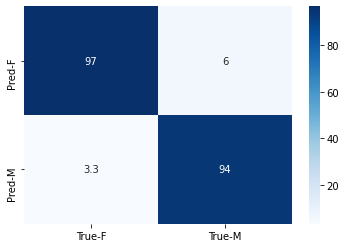

In [22]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cf_matrix_train = confusion_matrix(y, train_predict_hard)
sns.heatmap(cf_matrix_train/sum(cf_matrix_train) * 100.0,
            cmap="Blues", annot=True, xticklabels=['True-F', 'True-M'],
            yticklabels=['Pred-F', 'Pred-M'])
plt.plot()

[]

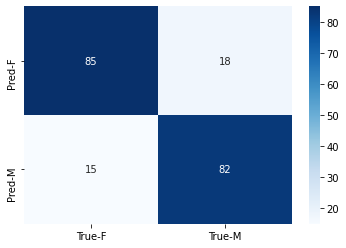

In [23]:
cf_matrix_val = confusion_matrix(y_val, val_predict_hard)
sns.heatmap(cf_matrix_val/sum(cf_matrix_val) * 100.0,
            cmap="Blues", annot=True, xticklabels=['True-F', 'True-M'],
            yticklabels=['Pred-F', 'Pred-M'])
plt.plot()
